# BigEarthNet Dataset
## InternImage-T

In [14]:
import os
import random
import re

import numpy as np
import rasterio
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm_notebook

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

g = torch.Generator()
g.manual_seed(seed)

In [3]:
root_dir = "./data"
img_root_dir = os.path.join(root_dir, "BigEarthNet-S2")
label_root_dir = os.path.join(root_dir, "Reference_Maps")

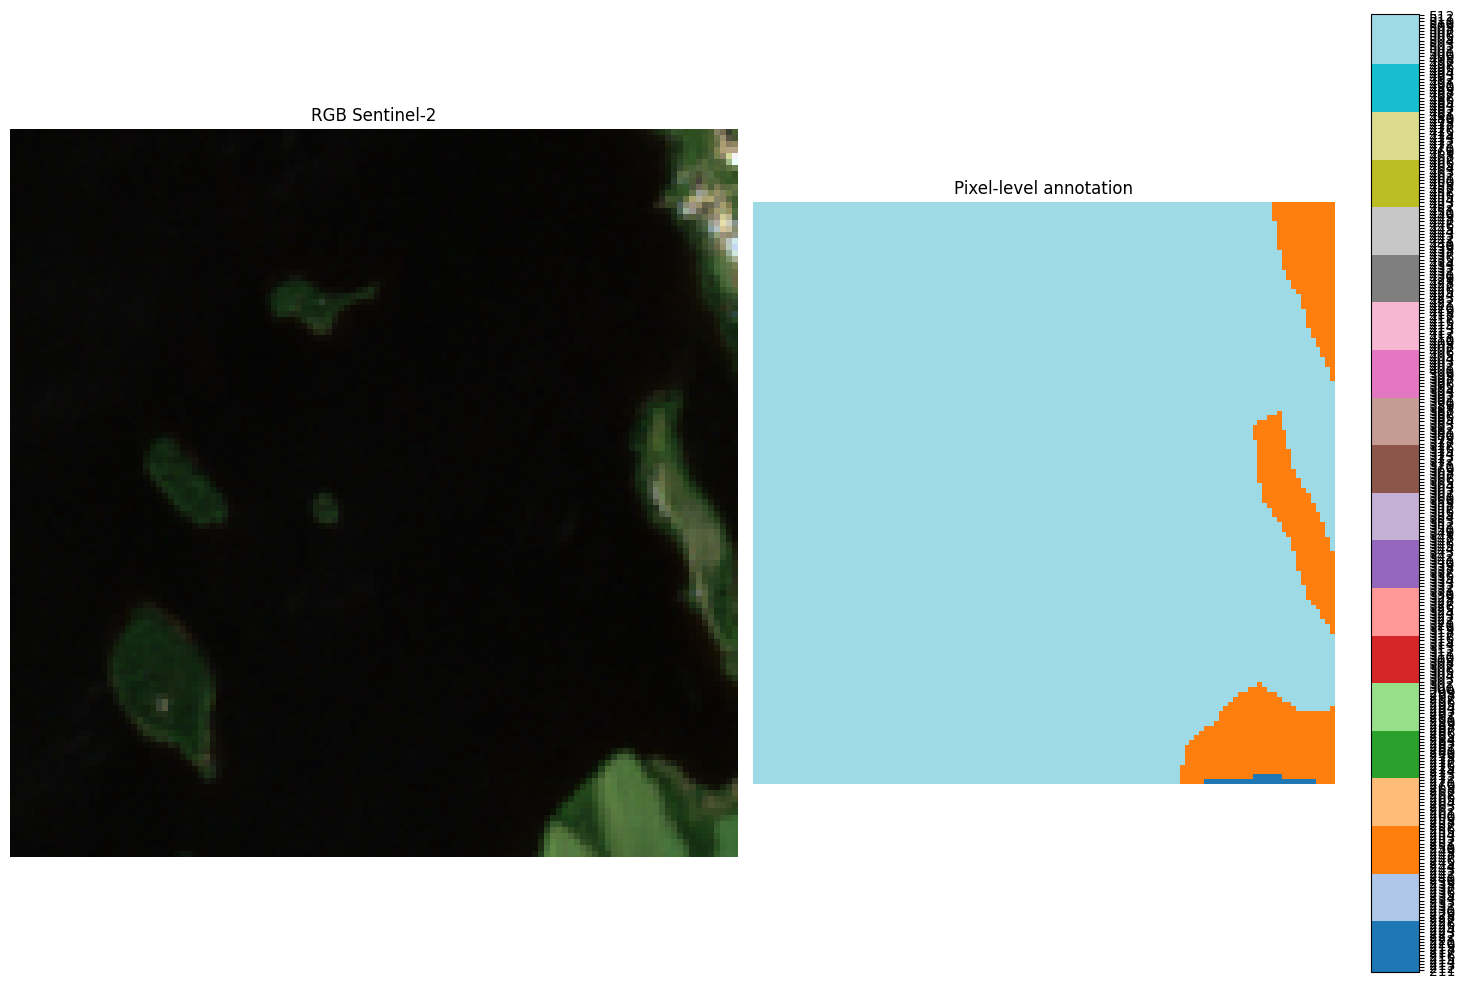

In [43]:
tile_id = "S2A_MSIL2A_20170701T093031_N9999_R136_T35VPK"
patch_id = tile_id + "_20_20"
img_dir = os.path.join(img_root_dir, tile_id, patch_id)
label_dir = os.path.join(label_root_dir, tile_id, patch_id, patch_id + "_reference_map.tif")


def display_image_and_label(image_dir, label_path):
    band_paths = [os.path.join(image_dir, f"{patch_id}_B0{i}.tif") for i in [4, 3, 2]]

    with rasterio.open(band_paths[0]) as red_src, \
            rasterio.open(band_paths[1]) as green_src, \
            rasterio.open(band_paths[2]) as blue_src:
        red = red_src.read(1)
        green = green_src.read(1)
        blue = blue_src.read(1)

        rgb_image = np.dstack((red, green, blue))

        rgb_image = np.clip(rgb_image / np.max(rgb_image), 0, 1)

    with rasterio.open(label_path) as src:
        labels = src.read(1)

    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    ax[0].imshow(rgb_image)
    ax[0].set_title('RGB Sentinel-2')
    ax[0].axis('off')

    cmap = plt.get_cmap('tab20', np.max(labels) - np.min(labels) + 1)
    im = ax[1].imshow(labels, cmap=cmap, vmin=np.min(labels) - 0.5, vmax=np.max(labels) + 0.5)
    ax[1].set_title('Pixel-level annotation')
    ax[1].axis('off')

    fig.colorbar(im, ax=ax[1], ticks=np.arange(np.min(labels), np.max(labels) + 1))

    plt.tight_layout()
    plt.show()


display_image_and_label(img_dir, label_dir)


In [15]:
class BigEarthNetSentinel2Dataset(Dataset):
    def __init__(self, img_root_dir, label_root_dir, bands=None, seqlength=32, transform=None):
        self.img_root_dir = img_root_dir
        self.label_root_dir = label_root_dir
        self.bands = bands if bands is not None else ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B08',
                                                      'B09', 'B11', 'B12']
        self.seqlength = seqlength
        self.transform = transform

        self.samples = list()
        
        progress_bar = tqdm_notebook(total=549488, desc="Fetching images")
        for root, dirs, files in os.walk(self.img_root_dir):
            if len(files) > 0 and files[0].endswith("_B01.tif"):
                img_path = os.path.join(root, files[0])
                label_path = img_path.replace(self.img_root_dir, self.label_root_dir).replace('_B01.tif',
                                                                                              '_reference_map.tif')
                if os.path.exists(label_path):
                    self.samples.append(img_path)
                    progress_bar.update(1)
                        
        progress_bar.close()
        print("Total samples: ", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]

        label_path = path.replace(self.img_root_dir, self.label_root_dir).replace('_B01.tif', '_reference_map.tif')
        label, _ = read_tif(label_path)

        dates = self.get_dates(os.path.dirname(path))

        if len(dates) < self.seqlength:
            raise ValueError(f"Sequence length too short. Required length: {self.seqlength}")

        dates = random.sample(dates, self.seqlength)

        x_bands_10m = list()
        x_bands_20m = list()
        x_bands_60m = list()

        for date_path in dates:
            # date_path = os.path.join(path, date)
            bands_10m, bands_20m, bands_60m = self.load_bands(date_path)
            x_bands_10m.append(bands_10m)
            x_bands_20m.append(bands_20m)
            x_bands_60m.append(bands_60m)

        x_bands_10m = np.array(x_bands_10m) * 1e-4
        x_bands_20m = np.array(x_bands_20m) * 1e-4
        x_bands_60m = np.array(x_bands_60m) * 1e-4

        x_bands_10m = torch.from_numpy(x_bands_10m)
        x_bands_20m = torch.from_numpy(x_bands_20m)
        x_bands_60m = torch.from_numpy(x_bands_60m)

        # Bands resampling
        x_bands_20m = F.interpolate(x_bands_20m, size=x_bands_10m.shape[2:4], mode='bilinear')
        x_bands_60m = F.interpolate(x_bands_60m, size=x_bands_10m.shape[2:4], mode='bilinear')

        x = torch.cat((x_bands_10m, x_bands_20m, x_bands_60m), 1)

        # Permute channels with time_series (t x c x h x w) -> (c x t x h x w)
        x = x.permute(1, 0, 2, 3)

        x = x.float()

        label = torch.from_numpy(label).long()

        if self.transform is not None:
            x = self.transform(x)
            label = self.transform(label)

        return x, label

    def load_bands(self, path):
        """
        Load specified bands into different lists. One list for each band resolution

        :param path: Path to band files
        :return: a tuple of lists (10m, 20m, 60m)
        """
        bands_10m, bands_20m, bands_60m = [], [], []

        for band in self.bands:
            band_path = path.replace('_B01.tif', f'_{band}.tif')

            if os.path.exists(band_path):
                band_img, _ = read_tif(band_path)

                if band in ['B02', 'B03', 'B04', 'B08']:
                    bands_10m.append(band_img)
                elif band in ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12']:
                    bands_20m.append(band_img)
                elif band in ['B01', 'B09']:
                    bands_60m.append(band_img)

        return bands_10m, bands_20m, bands_60m

    def get_dates(self, path):
        """
        Extract temporal series given a path. The path have to contain the tail_id and the patch_id

        :param path: Path that contain the sample
        :return: a list of path corresponding to the temporal series of a given tail_id and patch_id
        """
        tile_id = path.split('_')[-3]
        patch_id = f"{path.split('_')[-2]}_{path.split('_')[-1]}"

        pattern = re.compile(r'S2[AB]_MSIL2A_(\d{8})T\d+_N\d+_R\d+_' + tile_id + r'.*_' + patch_id)

        dates = []

        for sample in self.samples:
            match = pattern.search(sample)
            if match:
                # date = match.group(1)
                dates.append(sample)

        # dates = list(set(dates))
        # dates.sort()
        return dates


def read_tif(file):
    """
    Read a TIFF file and return the image and the metadata

    :param file: Path to the TIFF file
    :return: a tuple containing the image and the metadata
    """
    with rasterio.open(file) as src:
        return src.read(1), src.profile

In [16]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

dataset = BigEarthNetSentinel2Dataset(
    img_root_dir='data/BigEarthNet-S2',
    label_root_dir='data/Reference_Maps',
    seqlength=2,
    transform=None
)


Fetching images:   0%|          | 0/549488 [00:00<?, ?it/s]

Total samples:  549488


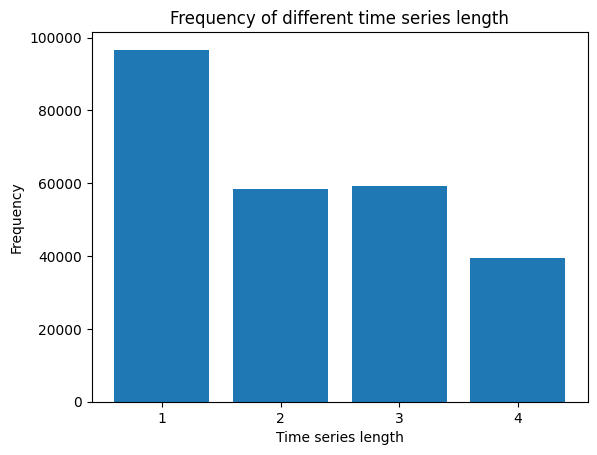

In [41]:
# data/BigEarthNet-S2/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57/S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B01.tif
from collections import Counter
stats_t_p = {}
for index, sample in enumerate(dataset.samples):
    patch_dir = sample.split('\\')[-2]
    tile_patch = f"{patch_dir.split('_')[-3]}_{patch_dir.split('_')[-2]}_{patch_dir.split('_')[-1]}"
    stats_t_p[tile_patch] = 1 if tile_patch not in stats_t_p else stats_t_p[tile_patch] + 1
    
values_t_p = Counter(stats_t_p.values())
plt.bar(values_t_p.keys(), values_t_p.values())
plt.xticks(list(values_t_p.keys()))
plt.xlabel('Time series length')
plt.ylabel('Frequency')
plt.title("Frequency of different time series length")
plt.show()

In [42]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True
)

In [19]:
first_batch = next(iter(dataloader))

for index, value in enumerate(first_batch):
    print(f"Element {index}: {value}")

Element 0: tensor([[[[[1.0120e-01, 7.3300e-02, 9.2600e-02,  ..., 1.7120e-01,
            1.8520e-01, 1.5980e-01],
           [3.6600e-02, 2.2900e-02, 4.8900e-02,  ..., 1.6080e-01,
            1.6220e-01, 1.6780e-01],
           [1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 1.4600e-01,
            1.6440e-01, 1.7000e-01],
           ...,
           [9.1600e-01, 9.1120e-01, 9.3440e-01,  ..., 8.8500e-02,
            7.0500e-02, 1.0000e-04],
           [9.1280e-01, 9.4240e-01, 9.9840e-01,  ..., 6.4400e-02,
            1.1580e-01, 2.2300e-02],
           [1.0248e+00, 9.6160e-01, 9.4320e-01,  ..., 3.9200e-02,
            9.0800e-02, 3.5800e-02]],

          [[2.1300e-02, 2.2000e-02, 2.4900e-02,  ..., 2.0200e-02,
            1.9600e-02, 2.2800e-02],
           [1.8900e-02, 1.7200e-02, 1.8400e-02,  ..., 2.0600e-02,
            2.1100e-02, 1.9600e-02],
           [1.8100e-02, 1.8100e-02, 1.4800e-02,  ..., 2.0000e-02,
            2.0200e-02, 1.9700e-02],
           ...,
           [5.9600e-02, 5.61

In [9]:
first_batch[0].shape


torch.Size([8, 12, 2, 120, 120])

In [10]:
first_batch[1].shape


torch.Size([8, 120, 120])